# Оптимизация управления персоналом

# Описание проекта

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
У нас поставлено несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика, а вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Описание данных

* **id** — уникальный идентификатор сотрудника;
* **dept** — отдел, в котором работает сотрудник;
* **level** — уровень занимаемой должности;
* **workload** — уровень загруженности сотрудника;
* **employment_years** — длительность работы в компании (в годах);
* **last_year_promo** — показывает, было ли повышение за последний год;
* **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
* **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
* **salary** — ежемесячная зарплата сотрудника;
* **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, целевой признак.

# План работы

**Задача 1: предсказание уровня удовлетворённости сотрудника**

[**Шаг 1. Загрузка данных**](#step_01)

[**Шаг 2. Предобработка данных**](#step_02)

[**Шаг 3. Исследовательский анализ данных**](#step_03)

[**Шаг 4. Корреляционный анализ**](#step_04)

[**Шаг 5. Подготовка данных**](#step_05)

[**Шаг 6. Обучение модели**](#step_06)

**Задача 2: предсказание увольнения сотрудника из компании**

[**Шаг 1. Загрузка данных**](#step_07)

[**Шаг 2. Предобработка данных**](#step_08)

[**Шаг 3. Исследовательский анализ данных**](#step_09)

[**Шаг 4. Добавление нового входного признака**](#step_10)

[**Шаг 5. Корреляционный анализ**](#step_11)

[**Шаг 6. Подготовка данных**](#step_12)

[**Шаг 7. Обучение модели**](#step_13)

# Библиотека и методы

**Библиотеки**

In [1]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import shap
import phik

import scipy.stats as stats

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler, LabelEncoder

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier

from sklearn.metrics import make_scorer, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

**Методы**

In [5]:
# проверка пропусков и дубликатов
def check_nan_duplicates(df):
    print((df.isna().sum() / len(df)) * 100, '\n')
    print('---------------- \n')
    print('Проверка на явные дубликаты: ')
    print(f'Кол-во явных дубликатов: {df.duplicated().sum()} \n')
    print('---------------- \n')
    print('Проверка на не явные дубликаты: ')
    cols = df.select_dtypes(include='object').columns.to_list()
    for i in cols:
        print(i, df[i].unique(), '\n')
    print('---------------- \n')
    df.info()
    
# построение графиков
def plot_(df):
    obj_cols = df.select_dtypes(include='object').columns.to_list()
    num_cols = df.select_dtypes(exclude='object').columns.to_list()
    
    num_cols.remove('employment_years')
    num_cols.remove('supervisor_evaluation')
    num_cols.remove('id')
    obj_cols = np.append(obj_cols, 'employment_years')
    obj_cols = np.append(obj_cols, 'supervisor_evaluation')
    if len(obj_cols) != 0:
        fig, ax = plt.subplots(nrows=len(obj_cols), ncols=1)
        plt.subplots_adjust(hspace=0.8)
    
        k = 0
        for i in obj_cols:
            df.groupby(i)[i].count().plot(y=i, 
                                          kind='bar', 
                                          grid=True, 
                                          figsize=(10,50), 
                                          title=i, 
                                          ax=ax[k], 
                                          xlabel=(i), 
                                          ylabel=('Частота'), 
                                         )
            k += 1
    if len(num_cols) > 1:
        fig, ax = plt.subplots(nrows=len(num_cols), ncols=1)
        plt.subplots_adjust(hspace=0.8)
        k = 0
        for i in num_cols:
                df.plot(y=i, 
                        kind='hist', 
                        grid=True, 
                        figsize=(10,15),  
                        title=i, 
                        ax=ax[k],  
                       )
                ax[k].set_xlabel(i)
                ax[k].set_ylabel('Частота')
                k += 1
    else:
        for i in num_cols:
                df.plot(y=i, 
                        kind='hist', 
                        grid=True, 
                        figsize=(10,6),  
                        title=i, 
                        xlabel=(i), 
                        ylabel=('Частота'),
                       )
    num_cols = np.append(num_cols, 'employment_years')
    num_cols = np.append(num_cols, 'supervisor_evaluation')
    fig, ax = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(10,30))
    plt.subplots_adjust(hspace=0.8)
    k = 0
    for i in num_cols:
            ax[k].set_title(i)
            ax[k].boxplot(df[i])
            plt.xlabel('')
            k+=1
    None

# метрика
def custom_metric(y_true, y_pred):
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)
    return 200 / len(y_true_np) * np.sum(np.abs(y_true_np - y_pred_np) / (np.abs(y_true_np) + np.abs(y_pred_np)) )

# график уволившегося сотрудника

def plot_quit(df, column):
    #obj_cols = df.select_dtypes(include='object').columns.to_list()
    fig, ax = plt.subplots(nrows=len(df.columns)-3, ncols=1)
    plt.subplots_adjust(hspace=0.9)
    k = 0
    for i in column:
        df.groupby(i)['quit'].apply(lambda x: (x=='yes').sum()).plot(y=i, 
                                            kind='bar', 
                                            grid=True, 
                                            figsize=(10,40), 
                                            title=i, 
                                            ax=ax[k], 
                                            xlabel=(i), 
                                            ylabel=('Частота'), 
                                            )
        k += 1
    None

# Задача 1: предсказание уровня удовлетворённости сотрудника

<a id='step_01'></a>

## Шаг 1. Загрузка данных

### Задание 1. Загрузить и изучить тренировочную выборку

In [6]:
train_job_satisfaction_rate = pd.read_csv('train_job_satisfaction_rate.csv')
display(train_job_satisfaction_rate.head())
train_job_satisfaction_rate.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


### Вывод

1) Присутствуют пропуски в признаках *dept*, *level*

### Задание 2. Загрузить и изучить входные признаки тестовой выборки

In [7]:
test_features = pd.read_csv('test_features.csv')
display(test_features.head())
test_features.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


### Вывод

1) Присутствуют пропуски в признаках *dept*, *level*

### Задание 3. Загрузить и изучить целевой признак тестовой выборки

In [8]:
test_target_job_satisfaction_rate = pd.read_csv('test_target_job_satisfaction_rate.csv')
display(test_target_job_satisfaction_rate.head())
test_target_job_satisfaction_rate.info()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


<a id='step_02'></a>

## Шаг 2. Предобработка данных

***train_job_satisfaction_rate***

### Задание 1. Обработать пропуски и дубликаты при необходимости 

In [9]:
check_nan_duplicates(train_job_satisfaction_rate)

id                       0.00
dept                     0.15
level                    0.10
workload                 0.00
employment_years         0.00
last_year_promo          0.00
last_year_violations     0.00
supervisor_evaluation    0.00
salary                   0.00
job_satisfaction_rate    0.00
dtype: float64 

---------------- 

Проверка на явные дубликаты: 
Кол-во явных дубликатов: 0 

---------------- 

Проверка на не явные дубликаты: 
dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan] 

level ['junior' 'middle' 'sinior' nan] 

workload ['medium' 'high' 'low'] 

last_year_promo ['no' 'yes'] 

last_year_violations ['no' 'yes'] 

---------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level  

In [10]:
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].str.replace('sinior', 'senior')
train_job_satisfaction_rate['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

### Вывод

1) Пропуски мы заполним в Pipeline

2) Явных дубликатов в данном DateFrame нет

3) Не явных дубликатов в данном DateFrame нет

***test_features***

### Задание 1. Обработать пропуски и дубликаты при необходимости 

In [11]:
check_nan_duplicates(test_features)

id                       0.00
dept                     0.10
level                    0.05
workload                 0.00
employment_years         0.00
last_year_promo          0.00
last_year_violations     0.00
supervisor_evaluation    0.00
salary                   0.00
dtype: float64 

---------------- 

Проверка на явные дубликаты: 
Кол-во явных дубликатов: 0 

---------------- 

Проверка на не явные дубликаты: 
dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] 

level ['junior' 'middle' 'sinior' nan] 

workload ['medium' 'low' 'high' ' '] 

last_year_promo ['no' 'yes'] 

last_year_violations ['no' 'yes'] 

---------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-nu

In [12]:
test_features['level'] = test_features['level'].str.replace('sinior', 'senior')
test_features['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

В *workload* и *dept* изменим пустые значения на nan

In [13]:
test_features.loc[test_features['dept'] == ' ', 'dept'] = np.nan
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [14]:
test_features.loc[test_features['workload'] == ' ', 'workload'] = np.nan
test_features['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

### Вывод

1) Пропуски мы заполним в Pipeline

2) Явных дубликатов в данном DateFrame нет

3) В workload и dept изменили пустые значения на nan

***test_target_job_satisfaction_rate***

### Задание 1. Обработать пропуски и дубликаты при необходимости 

In [15]:
check_nan_duplicates(test_target_job_satisfaction_rate)

id                       0.0
job_satisfaction_rate    0.0
dtype: float64 

---------------- 

Проверка на явные дубликаты: 
Кол-во явных дубликатов: 0 

---------------- 

Проверка на не явные дубликаты: 
---------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


### Вывод

1) Пропусков в данном DateFrame нет

2) Явных дубликатов в данном DateFrame нет

3) Не явных дубликатов в данном DateFrame нет

<a id='step_03'></a>

## Шаг 3. Исследовательский анализ данных

***train_job_satisfaction_rate***

### Задание 1. Вывести графики

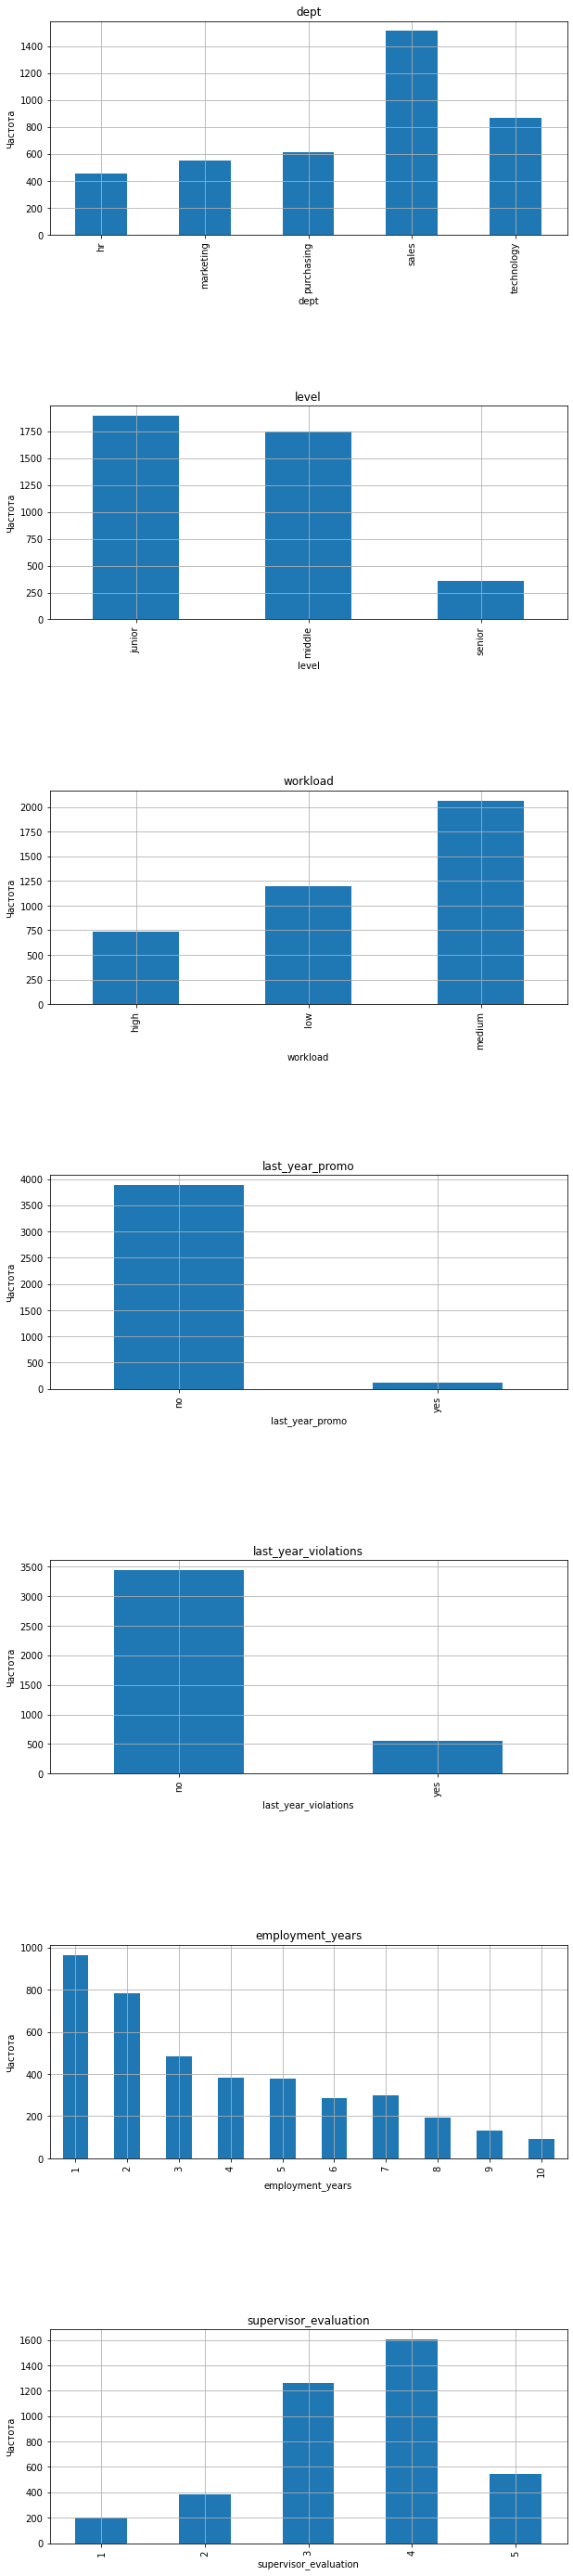

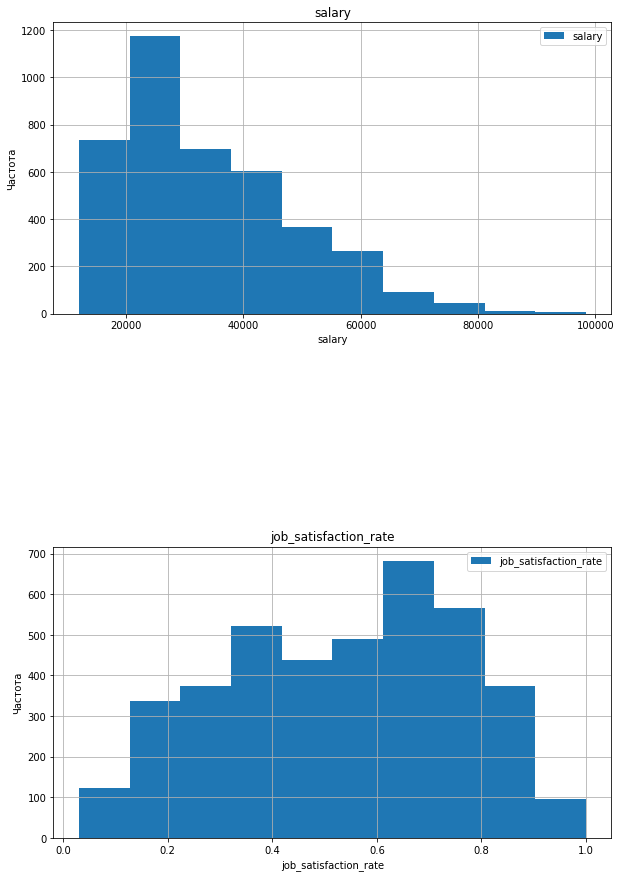

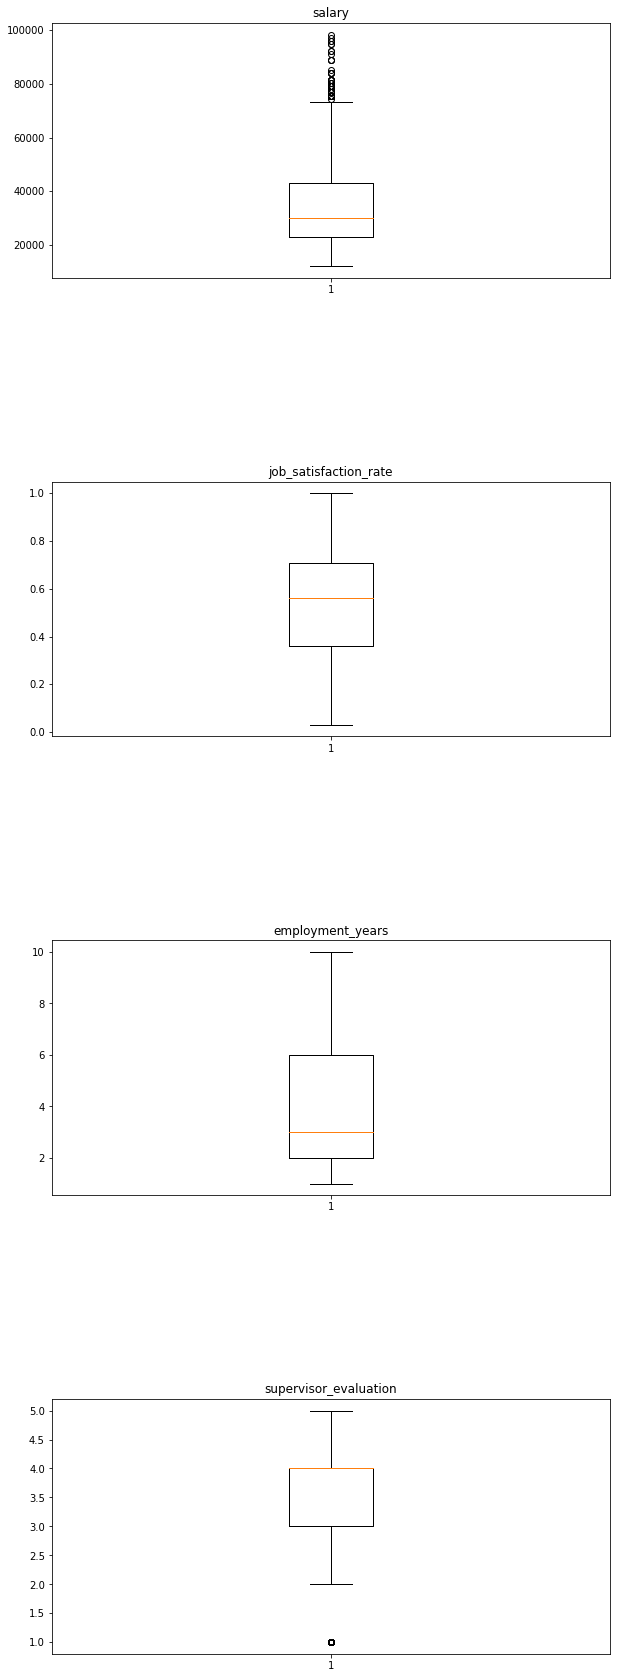

In [16]:
plot_(train_job_satisfaction_rate)

### Вывод

1) Сотрудников больше всего в отделе продаж

2) Больше всего в кампании junior и меньше senior

3) У большинства уровень загруженности средний

4) У большинства не было повышение з/п за последний год

5) Большинство сотрудников не нарушали трудовой договор за последний год

6) Чем больше трудовой стаж, тем меньше сотрудников

7) Больше всего сотрудников с оценокй 4

8) Больше всего сотрудников с з/п от 20 тыс до 30 тыс

### Задание 2. Обработать выбросы

### Вывод

1) Выбросы присутствуют в признаке *salary*, но мы их удалять не будем, так как есть специалисты которые могут получать такую з/п

2) В признаке *supervisor_evaluation* присутствует выброс, но мы его удалять не будем, так как оценка качества работы сотрудника, которую дал руководитель может равняться 1


### Задание 3. Проверить количественные признаки на нормальное распределние

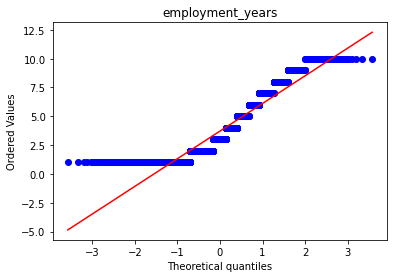

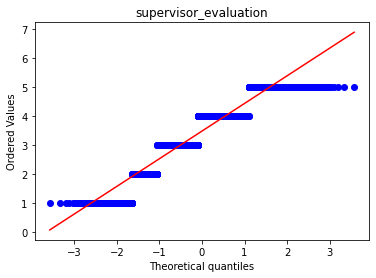

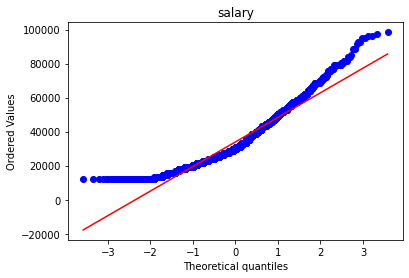

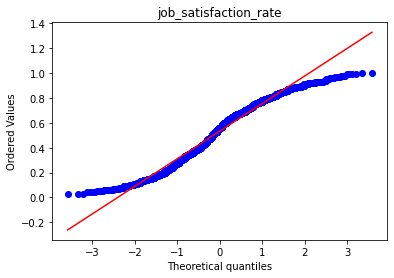

In [17]:
num_cols = train_job_satisfaction_rate.select_dtypes(exclude='object').columns.to_list()
for i in num_cols:
    if i != 'id':
        stats.probplot(train_job_satisfaction_rate[i], dist='norm', plot=pylab)
        plt.title(i)
        pylab.show()

### Вывод

Все количественные признаки нормально распределены

***test_features***

### Задание 1. Вывести графики

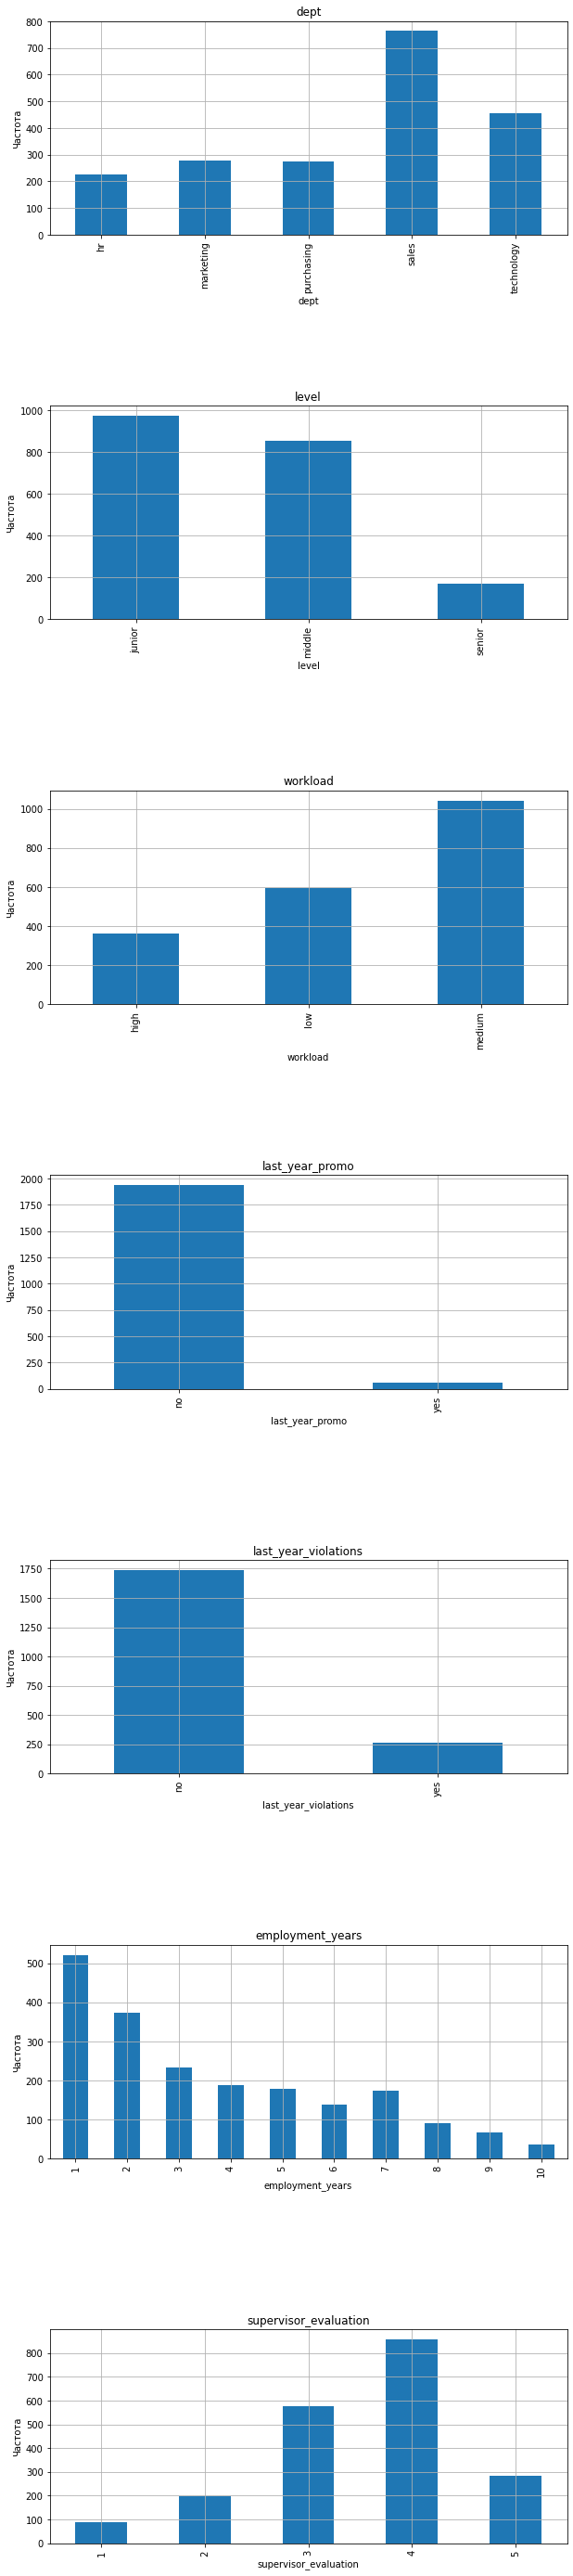

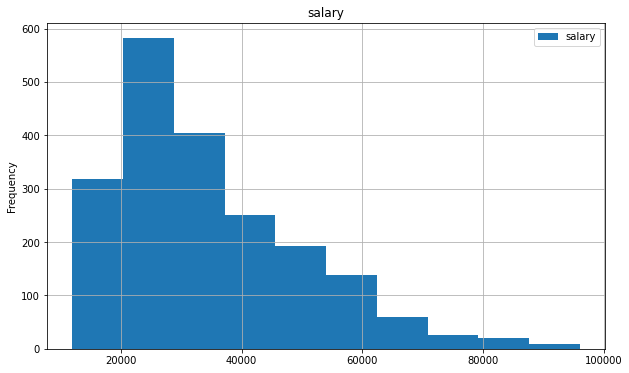

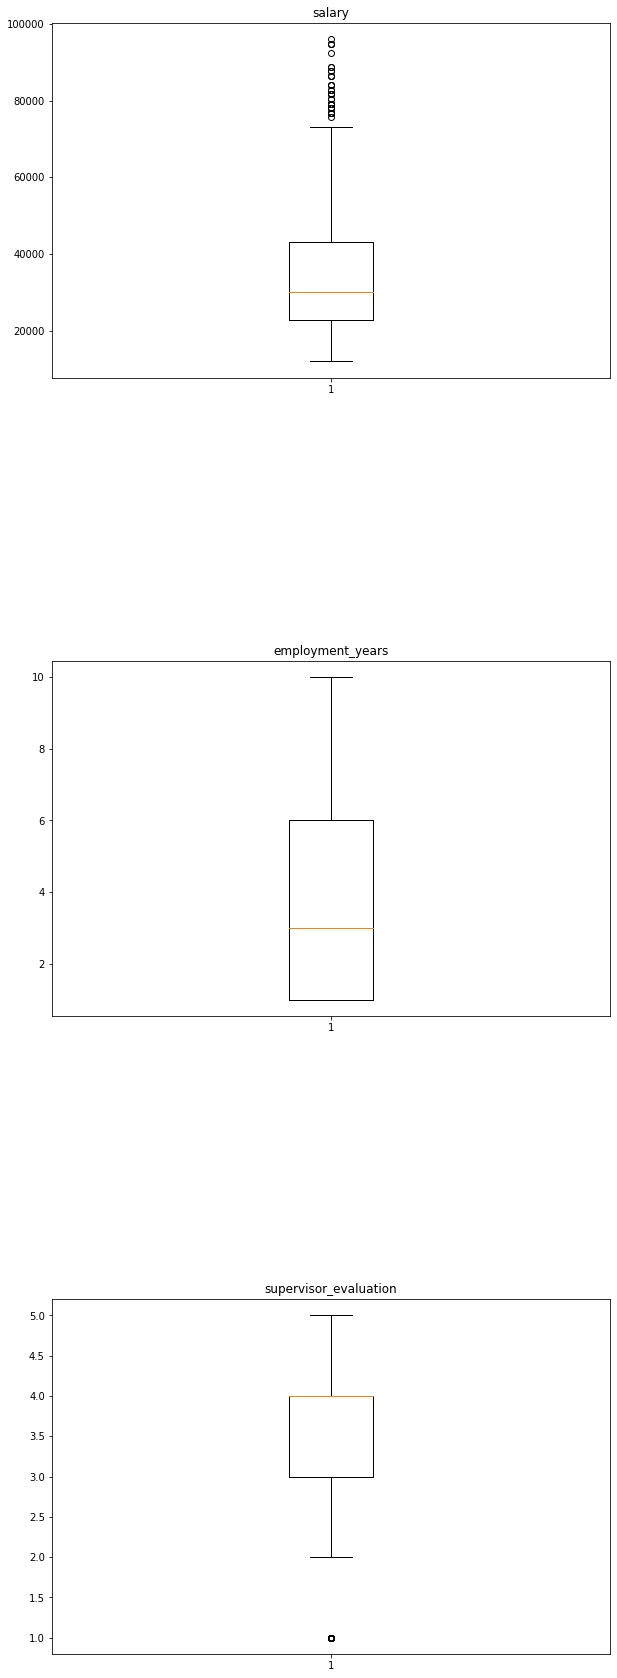

In [18]:
plot_(test_features)

### Вывод

1) Сотрудников больше всего в отделе продаж

2) Больше всего в кампании junior и меньше senior

3) У большинства уровень загруженности средний

4) У большинства не было повышение з/п за последний год

5) Большинство сотрудников не нарушали трудовой договор за последний год

6) Чем больше трудовой стаж, тем меньше сотрудников

7) Больше всего сотрудников с оценокй 4

8) Больше всего сотрудников с з/п от 20 тыс до 30 тыс

### Задание 2. Обработать выбросы

### Вывод

1) Выбросы присутствуют в признаке *salary*, но мы их удалять не будем, так как есть специалисты которые могут получать такую з/п

2) В признаке *supervisor_evaluation* присутствует выброс, но мы его удалять не будем, так как оценка качества работы сотрудника, которую дал руководитель может равняться 1

### Задание 3. Проверить количественные признаки на нормальное распределние

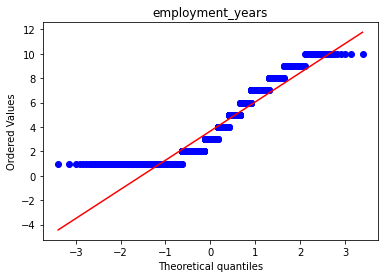

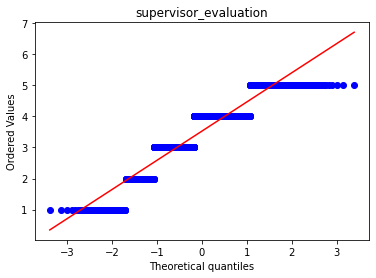

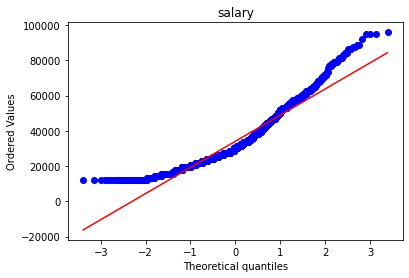

In [19]:
num_cols = test_features.select_dtypes(exclude='object').columns.to_list()
for i in num_cols:
    if i != 'id':
        stats.probplot(test_features[i], dist='norm', plot=pylab)
        plt.title(i)
        pylab.show()

### Вывод

Все количественные признаки нормально распределены

***test_target_job_satisfaction_rate***

### Задание 1. Вывести графики

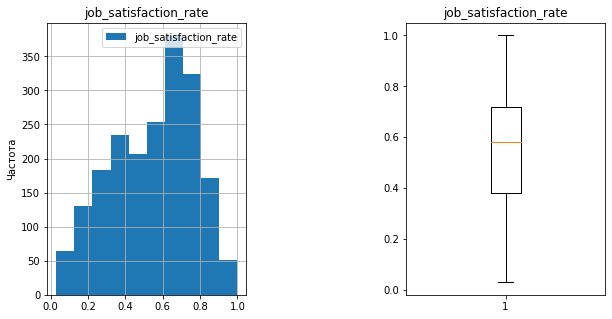

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2)

test_target_job_satisfaction_rate.plot(y='job_satisfaction_rate', 
                              kind='hist', 
                              grid=True, 
                              figsize=(10,5), 
                              title='job_satisfaction_rate', 
                              ax = ax[0],
                              xlabel=(''), 
                              ylabel=('Частота'), 
                                         )
ax[0].set_xlabel('')
ax[0].set_ylabel('Частота')

ax[1].boxplot(test_target_job_satisfaction_rate['job_satisfaction_rate'])

ax[1].set_title('job_satisfaction_rate')
    
plt.subplots_adjust(wspace=0.8)

None

### Задание 2. Обработать выбросы

### Вывод

В данном DataFrame нет выбросов 

<a id='step_04'></a>

### Задание 3. Проверить количественные признаки на нормальное распределние

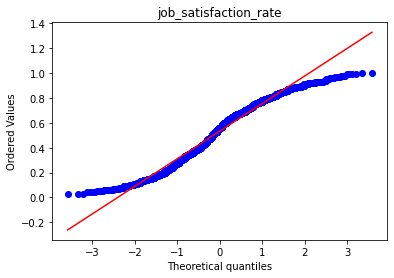

In [21]:
for i in test_target_job_satisfaction_rate.columns:
    if i != 'id':
        stats.probplot(train_job_satisfaction_rate[i], dist='norm', plot=pylab)
        plt.title(i)
        pylab.show()

### Вывод

Все количественные признаки нормально распределены

<a id='step_04'></a>

## Шаг 4. Корреляционный анализ

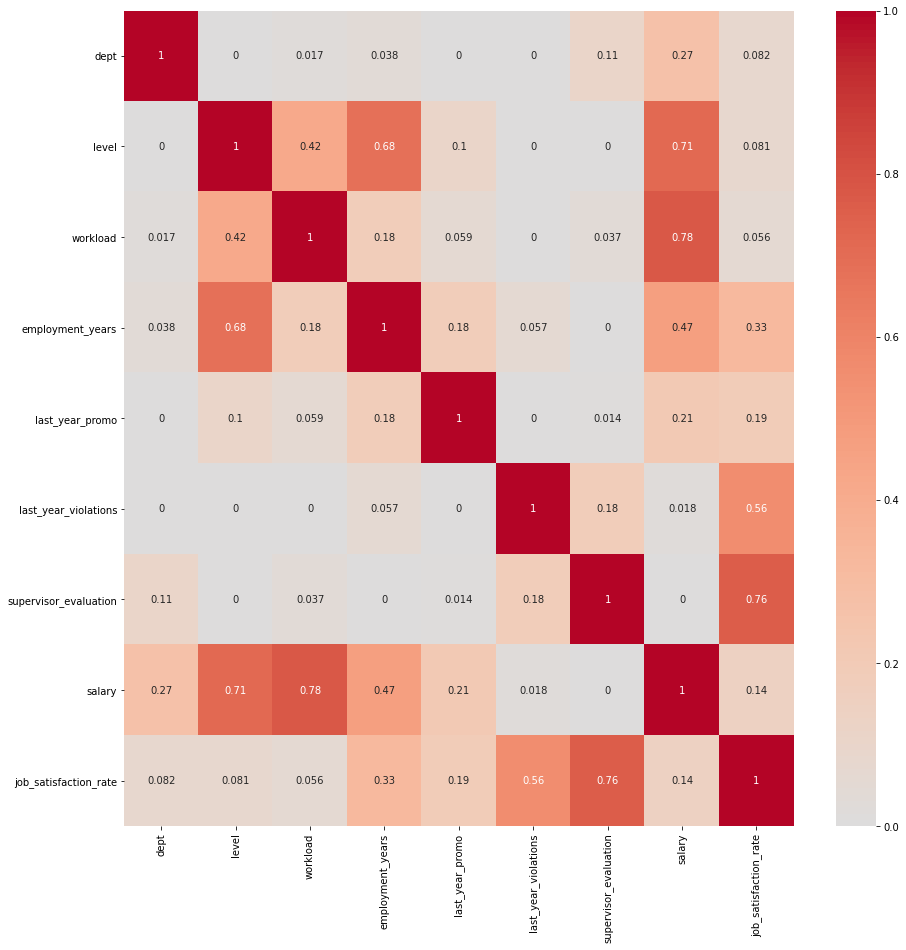

In [22]:
train_job_satisfaction_rate_no_id = train_job_satisfaction_rate.drop('id', axis=1)
corr = train_job_satisfaction_rate_no_id.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True)
None

### Вывод

1) Между признаками отсутсвует мультиколлинеарность 

2) 

* dept с таргетом не имеет линейную зависимость

* level с таргетом не имеет линейную зависимость

* workload с таргетом не имеет линейную зависимость

* employment_years с таргетом имеет умеренную линейную зависимость 

* last_year_promo с таргетом иммет слабую линейную зависимость 

* last_year_violations  с таргетом имеет заметную линейную зависимость 

* supervisor_evaluation с таргетом  имеет высокую линейную зависимость

* salary с таргетом иммет слабую линейную зависимость

### Вывод

***train_job_satisfaction_rate***

1) Сотрудников больше всего в отделе продаж

2) Больше всего в кампании junior и меньше senior

3) У большинства уровень загруженности средний

4) У большинства не было повышение з/п за последний год

5) Большинство сотрудников не нарушали трудовой договор за последний год

6) Чем больше трудовой стаж, тем меньше сотрудников

7) Больше всего сотрудников с оценокй 4

8) Больше всего сотрудников с з/п от 20 тыс до 30 тыс

9) Выбросы присутствуют в признаке salary, но мы их удалять не будем, так как есть специалисты которые могут получать такую з/п

10) В признаке supervisor_evaluation присутствует выброс, но мы его удалять не будем, так как оценка качества работы сотрудника, которую дал руководитель может равняться 1

11) Все количественные признаки нормально распределены

12) Между признаками отсутсвует мультиколлинеарность 

13) 

* dept с таргетом не имеет линейную зависимость

* level с таргетом не имеет линейную зависимость

* workload с таргетом не имеет линейную зависимость

* employment_years с таргетом имеет умеренную линейную зависимость 

* last_year_promo с таргетом иммет слабую линейную зависимость 

* last_year_violations  с таргетом имеет заметную линейную зависимость 

* supervisor_evaluation с таргетом  имеет высокую линейную зависимость

* salary с таргетом иммет слабую линейную зависимость

***test_features***

1) Сотрудников больше всего в отделе продаж

2) Больше всего в кампании junior и меньше senior

3) У большинства уровень загруженности средний

4) У большинства не было повышение з/п за последний год

5) Большинство сотрудников не нарушали трудовой договор за последний год

6) Чем больше трудовой стаж, тем меньше сотрудников

7) Больше всего сотрудников с оценокй 4

8) Больше всего сотрудников с з/п от 20 тыс до 30 тыс

9) Выбросы присутствуют в признаке salary, но мы их удалять не будем, так как есть специалисты которые могут получать такую з/п

10) В признаке supervisor_evaluation присутствует выброс, но мы его удалять не будем, так как оценка качества работы сотрудника, которую дал руководитель может равняться 1

11) Все количественные признаки нормально распределены



<a id='step_05'></a>

## Шаг 5. Подготовка данных

In [23]:
train_job_satisfaction_rate = train_job_satisfaction_rate.drop('id', axis=1)
check_nan_duplicates(train_job_satisfaction_rate)

dept                     0.15
level                    0.10
workload                 0.00
employment_years         0.00
last_year_promo          0.00
last_year_violations     0.00
supervisor_evaluation    0.00
salary                   0.00
job_satisfaction_rate    0.00
dtype: float64 

---------------- 

Проверка на явные дубликаты: 
Кол-во явных дубликатов: 245 

---------------- 

Проверка на не явные дубликаты: 
dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan] 

level ['junior' 'middle' 'senior' nan] 

workload ['medium' 'high' 'low'] 

last_year_promo ['no' 'yes'] 

last_year_violations ['no' 'yes'] 

---------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null

Удалим явные дубликаты 

In [24]:
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates()
check_nan_duplicates(train_job_satisfaction_rate)

dept                     0.159787
level                    0.106525
workload                 0.000000
employment_years         0.000000
last_year_promo          0.000000
last_year_violations     0.000000
supervisor_evaluation    0.000000
salary                   0.000000
job_satisfaction_rate    0.000000
dtype: float64 

---------------- 

Проверка на явные дубликаты: 
Кол-во явных дубликатов: 0 

---------------- 

Проверка на не явные дубликаты: 
dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan] 

level ['junior' 'middle' 'senior' nan] 

workload ['medium' 'high' 'low'] 

last_year_promo ['no' 'yes'] 

last_year_violations ['no' 'yes'] 

---------------- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   wo

In [25]:
RANDOM_STATE = 42
X_train = train_job_satisfaction_rate.drop('job_satisfaction_rate', axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

num_cols = X_train.select_dtypes(exclude='object').columns
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
ord_cols = ['level', 'workload']

smape = make_scorer(custom_metric, greater_is_better=False)

ohe_pipe = Pipeline(
[
    (
        'simpleImputer_ohe', 
        SimpleImputer(missing_values = np.nan, strategy='most_frequent')
    ),
    (
        'ohe',
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
    )
])

ord_pipe = Pipeline(
[
    (
        'simpleImputer_before_ord',
        SimpleImputer(missing_values = np.nan, strategy='most_frequent')
    ),
    (
        'ord',
        OrdinalEncoder(
            categories =[
                ['junior', 'middle', 'senior'],
                ['low', 'medium', 'high'],
            ],
            handle_unknown='use_encoded_value', unknown_value=np.nan
        )
    ),
    (
        'simpleImputer_after_ord',
        SimpleImputer(missing_values = np.nan, strategy='most_frequent')
    )
])

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols),
    ],
    remainder = 'passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2,11),
        'models__min_samples_leaf': range(1,11),
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

<a id='step_06'></a>

## Шаг 6. Обучение модели

In [26]:
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    random_state= RANDOM_STATE,
    cv=5,
    n_jobs=-1,
    scoring=smape
)

random_search.fit(X_train, y_train)

print('Лучшая модель и ее параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', -1 * random_search.best_score_)

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

**Предсказание уровня удовлетворённости сотрудника**

In [27]:
test_features = test_features.merge(test_target_job_satisfaction_rate, on='id', how='left')

In [28]:
test_id = test_features['id']
test_features = test_features.drop('id', axis=1)

In [29]:
X_test = test_features.drop('job_satisfaction_rate', axis=1)
y_test = test_features['job_satisfaction_rate']
y_pred = random_search.best_estimator_.predict(X_test)
print(f'SMAPE: {custom_metric(y_test, y_pred)}')

SMAPE: 14.853601085585513


Сравним лучшую модель с константной моделью 

In [30]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)
X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()
)

In [31]:
dummy_regr = DummyRegressor(strategy="mean")


dummy_regr.fit(X_train_p, y_train)

y_pred = dummy_regr.predict(X_test_p)

smape = custom_metric(y_test, y_pred)

print(f' SMAPE: {smape}')

 SMAPE: 38.26225790202238


Константная модель по метрике хуже предсказываем, чем лучшая модель в RandomizedSearcgCV

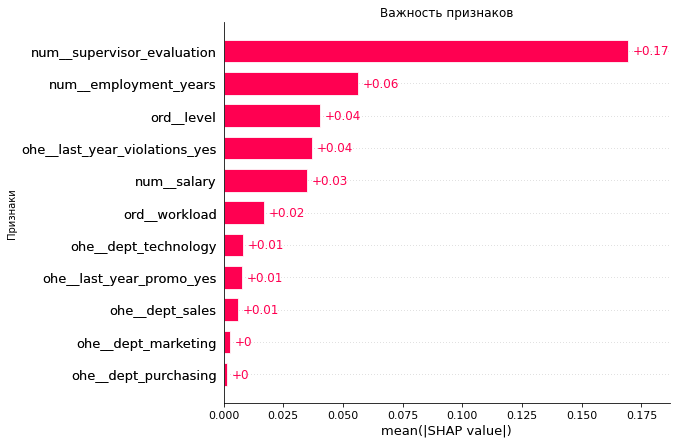

In [32]:
explainer = shap.Explainer(random_search.best_estimator_.named_steps.models)
shap_values = explainer(X_train_p)

plt.title("Важность признаков") 
plt.ylabel("Признаки")

shap.plots.bar(shap_values, max_display=20)


## Вывод

1) Уровень удовлетворенности меньше всего зависит от отдела в котором он работает

2) Уровень удовлетворенности, больше всего зависит, как его оценивает руководитель 

### Вывод

1) Мы обучили две модели: Линейную регресиию и Дерево решений

2) SMAPE лучшей модели равняется 14.8

3) Лучшие гиперпараметры для модели: 'models__min_samples_split': 4,'models__min_samples_leaf': 1, 'models__max_depth': 10,

4) Лучшая модель в RandomizedSearchCV намного лучше предсказывает чем константная модель 

# Задача 2: предсказание увольнения сотрудника из компании

## Шаг 1. Загрузка данных

<a id='step_07'></a>

### Задание 1. Загрузить и изучить тренировочную выборку

In [33]:
train_quit = pd.read_csv('train_quit.csv')
print(train_quit.info())
train_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


### Задание 1. Загрузить и изучить тестовую выборку

In [34]:
test_features = pd.read_csv('test_features.csv')
print(test_features.info())
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


### Вывод

Присутвуют пропуски в *dept* и *level*

### Задание 1. Загрузить и изучить целевую переменную

In [35]:
test_target_quit = pd.read_csv('test_target_quit.csv')
print(test_target_quit.info())
test_target_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<a id='step_08'></a>

## Шаг 2. Предобработка данных

***train_quit***

### Задание 1. Обработать пропуски и дубликаты при необходимости 

In [36]:
check_nan_duplicates(train_quit)

id                       0.0
dept                     0.0
level                    0.0
workload                 0.0
employment_years         0.0
last_year_promo          0.0
last_year_violations     0.0
supervisor_evaluation    0.0
salary                   0.0
quit                     0.0
dtype: float64 

---------------- 

Проверка на явные дубликаты: 
Кол-во явных дубликатов: 0 

---------------- 

Проверка на не явные дубликаты: 
dept ['sales' 'purchasing' 'marketing' 'technology' 'hr'] 

level ['middle' 'junior' 'sinior'] 

workload ['high' 'medium' 'low'] 

last_year_promo ['no' 'yes'] 

last_year_violations ['no' 'yes'] 

quit ['no' 'yes'] 

---------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level    

In [37]:
train_quit['level'] = train_quit['level'].str.replace('sinior', 'senior')
train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

### Вывод

1) Пропусков в данном DateFrame нет

2) Явных дубликатов в данном DateFrame нет

3) Не явных дубликатов в данном DateFrame нет

### Задание 1. Обработать пропуски и дубликаты при необходимости 

***test_features***

In [38]:
check_nan_duplicates(test_features)

id                       0.00
dept                     0.10
level                    0.05
workload                 0.00
employment_years         0.00
last_year_promo          0.00
last_year_violations     0.00
supervisor_evaluation    0.00
salary                   0.00
dtype: float64 

---------------- 

Проверка на явные дубликаты: 
Кол-во явных дубликатов: 0 

---------------- 

Проверка на не явные дубликаты: 
dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] 

level ['junior' 'middle' 'sinior' nan] 

workload ['medium' 'low' 'high' ' '] 

last_year_promo ['no' 'yes'] 

last_year_violations ['no' 'yes'] 

---------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-nu

In [39]:
test_features['level'] = test_features['level'].str.replace('sinior', 'senior')
test_features['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

В *dept* и *workload* изменим пустые значения на nan

In [40]:
test_features.loc[test_features['dept'] == ' ', 'dept'] = np.nan
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [41]:
test_features.loc[test_features['workload'] == ' ', 'workload'] = np.nan
test_features['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

### Вывод

1) Пропуски мы заполним в Pipeline

2) Явных дубликатов в данном DateFrame нет

3) В workload, level и dept изменили пустые значения на nan

***test_target_quit***

### Задание 1. Обработать пропуски и дубликаты при необходимости 

In [42]:
check_nan_duplicates(test_target_quit)

id      0.0
quit    0.0
dtype: float64 

---------------- 

Проверка на явные дубликаты: 
Кол-во явных дубликатов: 0 

---------------- 

Проверка на не явные дубликаты: 
quit ['yes' 'no'] 

---------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


### Вывод

1) Пропусков в данном DateFrame нет

2) Явных дубликатов в данном DateFrame нет

3) Не явных дубликатов в данном DateFrame нет

<a id='step_09'></a>

## Шаг 3. Исследовательский анализ

***train_quit***

### Задание 1. Вывести графики

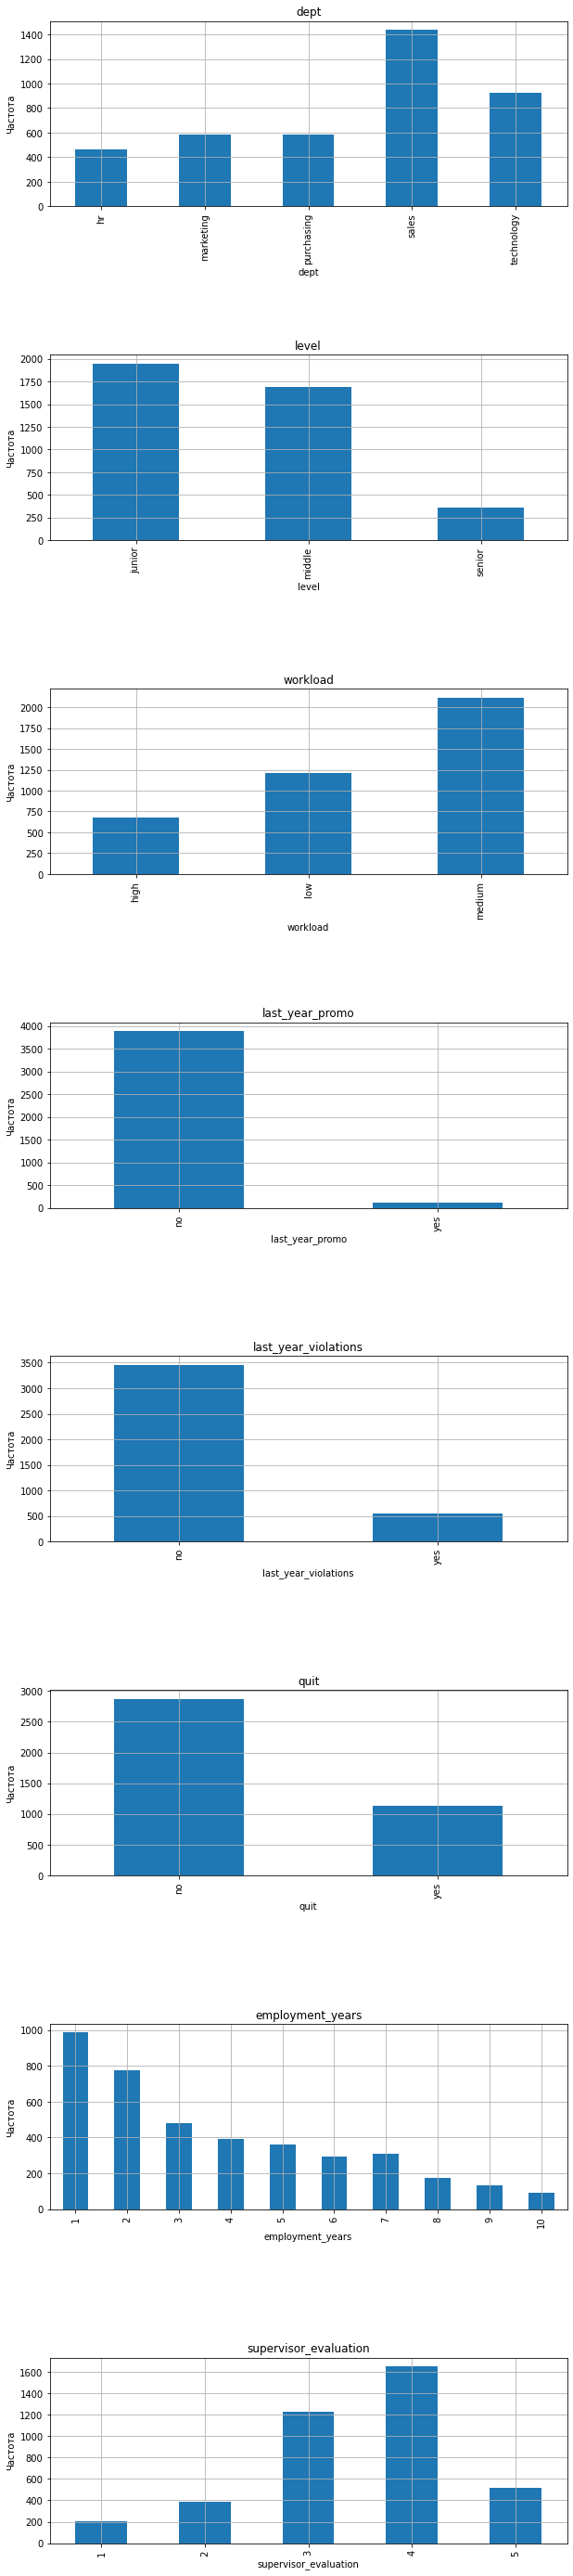

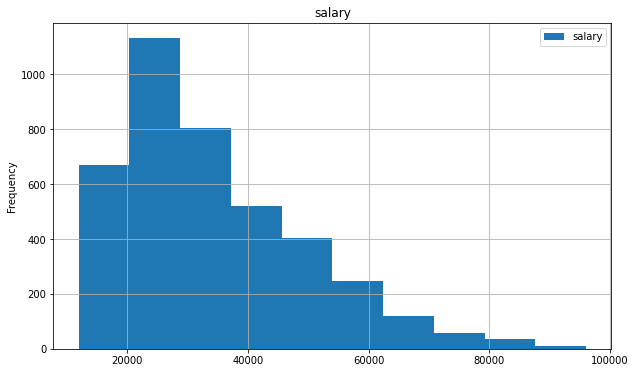

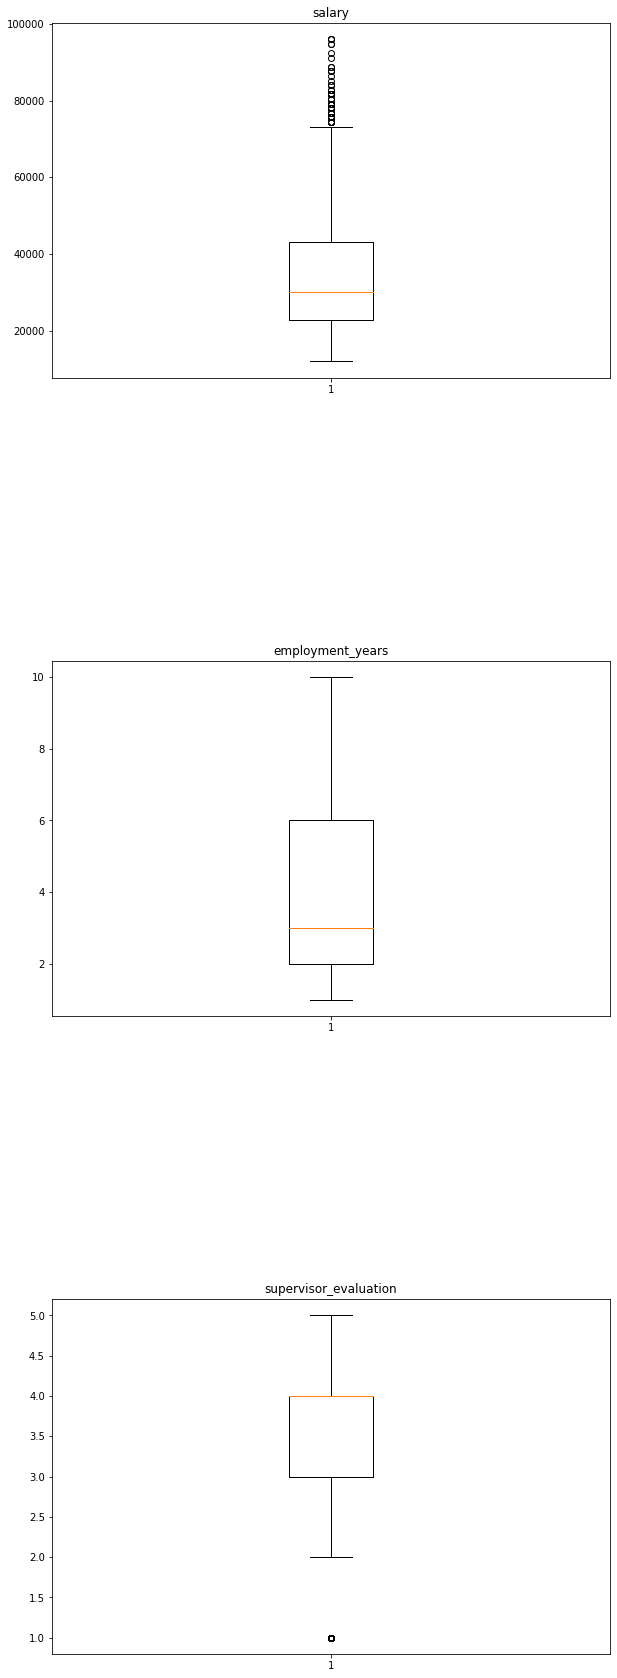

In [43]:
plot_(train_quit)

### Вывод

1) Сотрудников больше всего в отделе продаж

2) Больше всего в кампании junior и меньше senior

3) У большинства уровень загруженности средний

4) У большинства не было повышение з/п за последний год

5) Большинство сотрудников не нарушали трудовой договор за последний год

6) Чем больше трудовой стаж, тем меньше сотрудников

7) Больше всего сотрудников с оценокй 4

8) Больше всего сотрудников с з/п от 20 тыс до 30 тыс

9) В кампании мало сотрудников которые уволились 

### Задание 2. Обработать выбросы

### Вывод

1) Выбросы присутствуют в признаке *salary*, но мы их удалять не будем, так как есть специалисты которые могут получать такую з/п

2) В признаке *supervisor_evaluation* присутствует выброс, но мы его удалять не будем, так как оценка качества работы сотрудника, которую дал руководитель может равняться 1

### Задание 3. Проверить количественные признаки на нормальное распределние

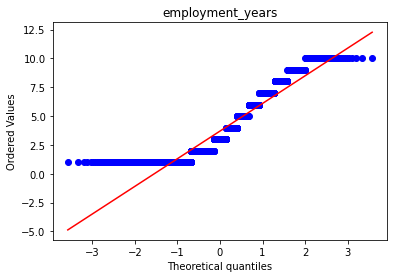

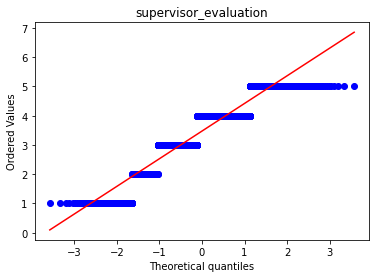

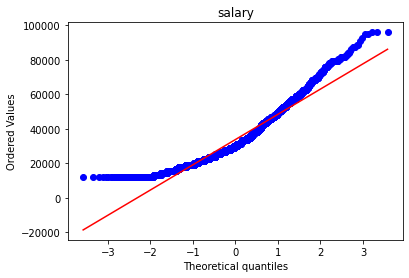

In [44]:
num_cols = train_quit.select_dtypes(exclude='object').columns.to_list()
for i in num_cols:
    if i != 'id':
        stats.probplot(train_quit[i], dist='norm', plot=pylab)
        plt.title(i)
        pylab.show()

### Вывод

Все количественные признаки нормально распределены

***test_features***

### Задание 1. Вывести графики

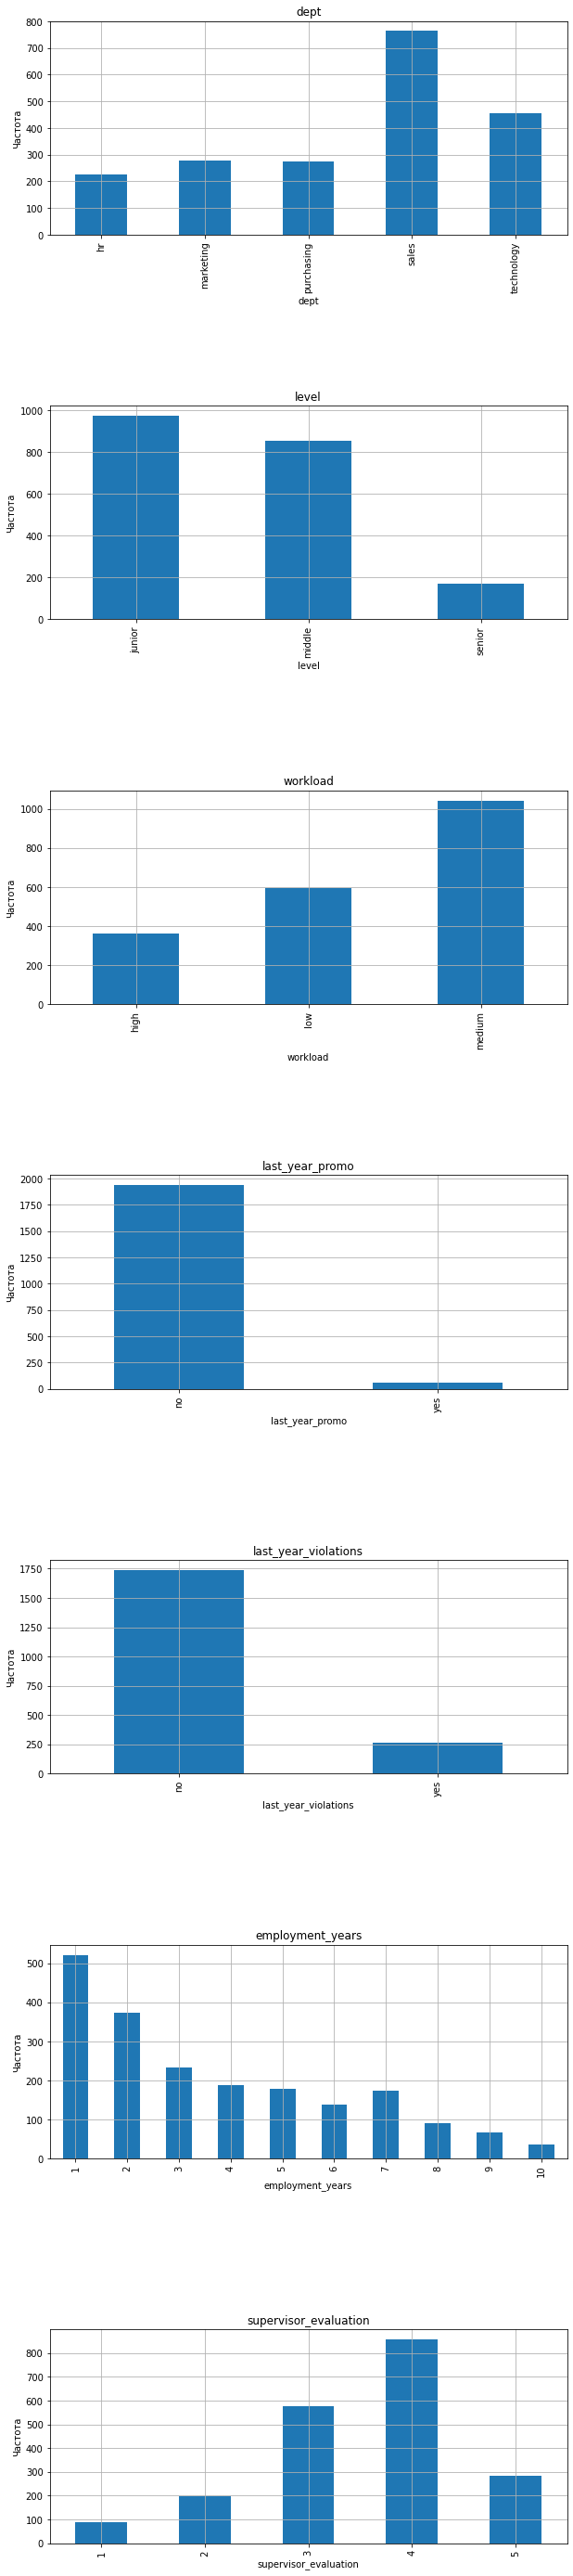

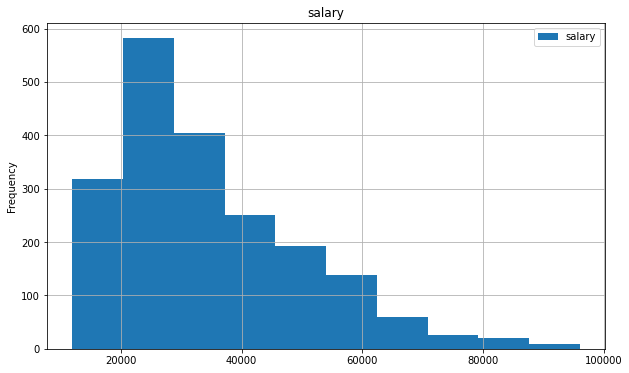

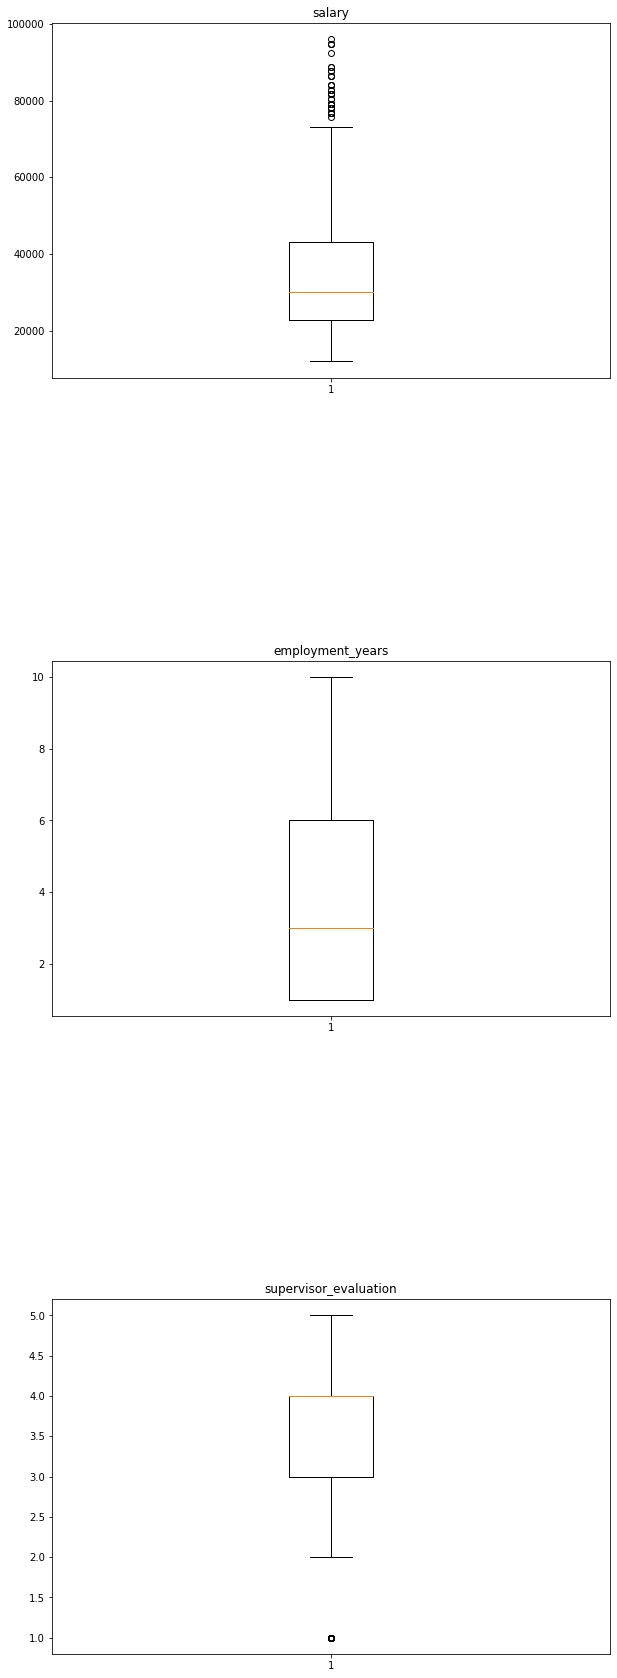

In [45]:
plot_(test_features)

### Вывод

1) Сотрудников больше всего в отделе продаж

2) Больше всего в кампании junior и меньше senior

3) У большинства уровень загруженности средний

4) У большинства не было повышение з/п за последний год

5) Большинство сотрудников не нарушали трудовой договор за последний год

6) Чем больше трудовой стаж, тем меньше сотрудников

7) Больше всего сотрудников с оценокй 4

8) Больше всего сотрудников с з/п от 20 тыс до 30 тыс 

### Задание 2. Обработать выбросы

### Вывод

1) Выбросы присутствуют в признаке *salary*, но мы их удалять не будем, так как есть специалисты которые могут получать такую з/п

2) В признаке *supervisor_evaluation* присутствует выброс, но мы его удалять не будем, так как оценка качества работы сотрудника, которую дал руководитель может равняться 1

### Задание 3. Проверить количественные признаки на нормальное распределние

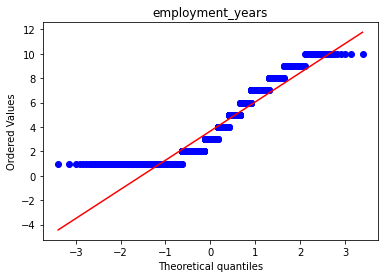

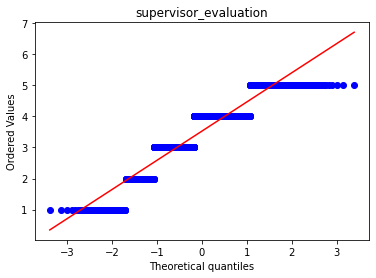

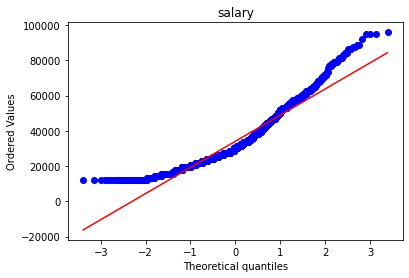

In [46]:
num_cols = test_features.select_dtypes(exclude='object').columns.to_list()
for i in num_cols:
    if i != 'id':
        stats.probplot(test_features[i], dist='norm', plot=pylab)
        plt.title(i)
        pylab.show()

### Вывод

Все количественные признаки нормально распределены

***test_target_quit***

### Задание 1. Вывести графики

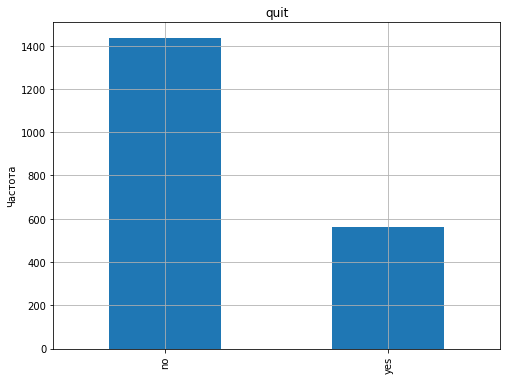

In [47]:
test_target_quit.groupby('quit')['quit'].count().plot(y=i, 
                                          kind='bar', 
                                          grid=True, 
                                          figsize=(8,6), 
                                          title='quit',  
                                          xlabel=(''), 
                                          ylabel=('Частота'), 
                                         )
None

### Вывод

1) В кампании мало сотрудников которые уволились

## Составить портрет «уволившегося сотрудника»

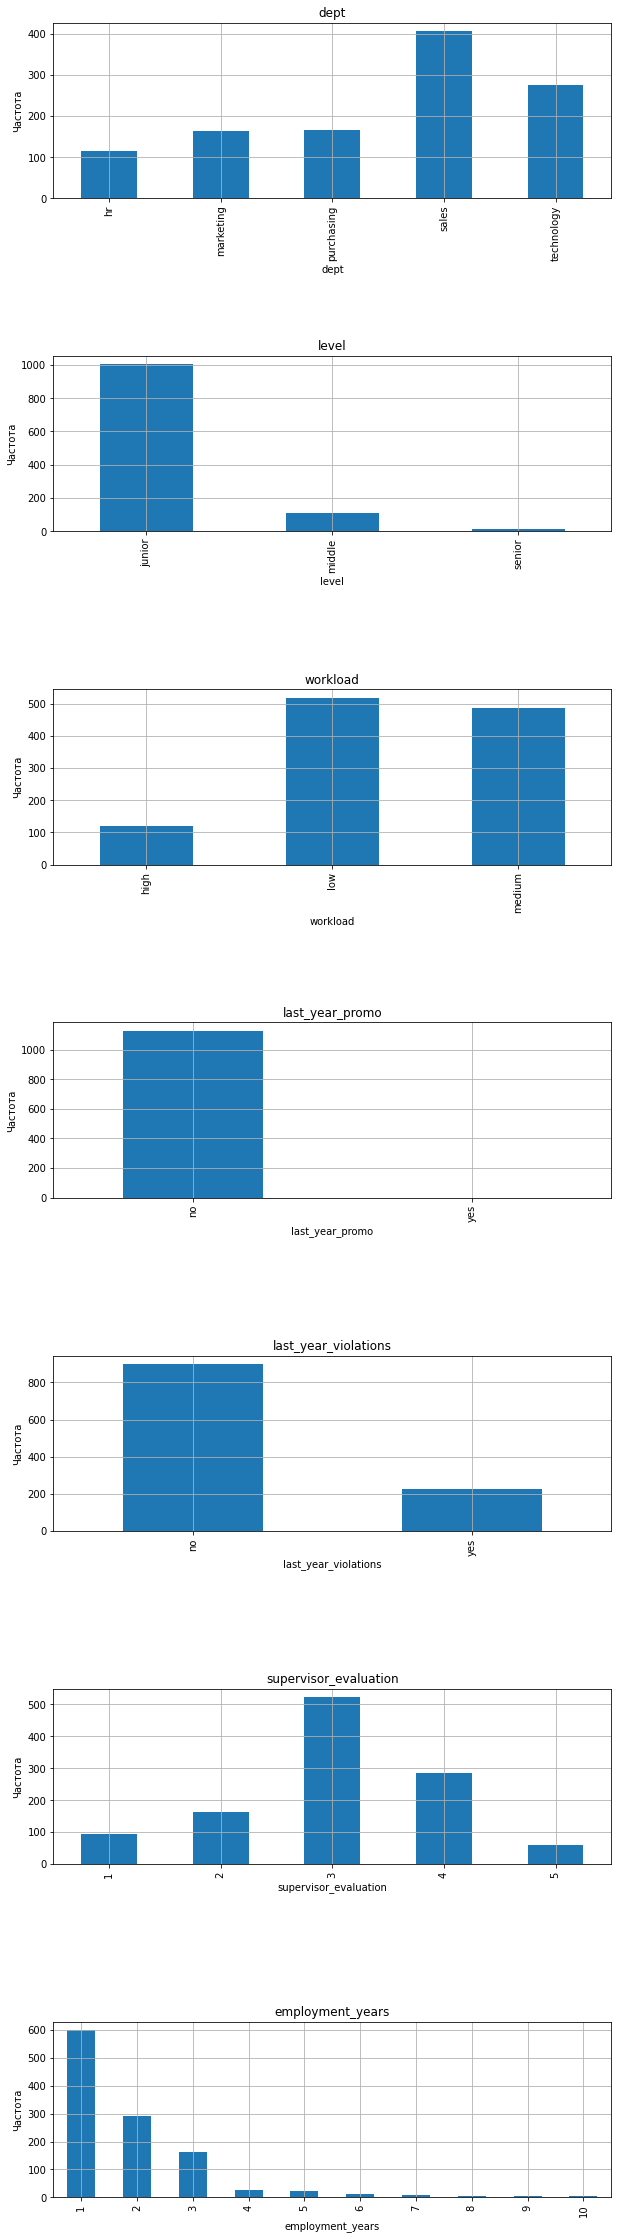

In [48]:
column = ['dept', 'level', 'workload','last_year_promo', 'last_year_violations', 'supervisor_evaluation','employment_years']
plot_quit(train_quit, column)

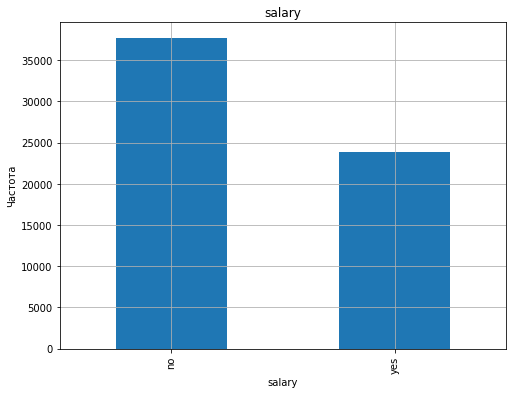

In [49]:
train_quit.groupby('quit')['salary'].mean().plot(y='salary', 
                                              kind='bar', 
                                              grid=True, 
                                              figsize=(8,6), 
                                              title='salary',  
                                              xlabel=('salary'), 
                                              ylabel=('Частота'), 
                                             )
None

### Вывод

1) Больше всего увольнений в отделе sales

2) Больше всего увольнений junior разработчиков

3) Больше всего увольнений сотрудников с низкой загруженностью

4) Больше всего увольнений тех сотрудников, у кого не было повышения з/п за последний год

5) Больше всего увольнений тех сотрудников, кто не нарушал трудовой договор за последний год

6) В сумме те сотрудники, которые были уволены меньше проработали, чем те которые остаться работать в организации

7) Чем больше стаж, тем меньше шанс, что сотрудник уволиться

8) Больше всего увольнений тех сотрудников, у кого оценка от руководителя равняется 3

9) Кто уволился в среднем з/п не превышала 25 тыс., а те кто продолжает работать, у них в среднем з/п выше 35 тыс.

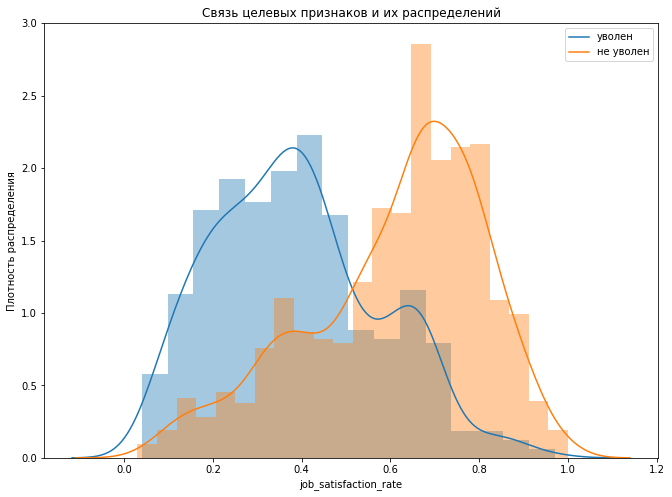

In [50]:
test_target_job_satisfaction_rate_quit = test_target_job_satisfaction_rate.merge(test_target_quit, on='id')
fig, ax = plt.subplots(figsize=(11, 8))

sns.distplot(test_target_job_satisfaction_rate_quit[test_target_job_satisfaction_rate_quit['quit'] == 'yes']['job_satisfaction_rate'])
sns.distplot(test_target_job_satisfaction_rate_quit[test_target_job_satisfaction_rate_quit['quit'] == 'no']['job_satisfaction_rate'])

ax.set_title('Cвязь целевых признаков и их распределений')
plt.ylabel("Плотность распределения")
ax.legend(['уволен', 'не уволен'])
None

### Вывод 

Оценка уровня удовлетворенности кто уволился намного меньше, чем у тех кто остался

<a id='step_10'></a>

## Шаг 4. Добавление нового входного признака

In [51]:
y_pred = random_search.best_estimator_.predict(train_quit)

train_quit['job_satisfaction_rate'] = y_pred

display(train_quit.head())

y_pred = random_search.best_estimator_.predict(test_features)

test_features['job_satisfaction_rate'] = y_pred

test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.602105
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.837297
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.402143
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.334444
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.813636


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.837297
1,686555,hr,junior,medium,1,no,no,4,30000,0.657826
2,467458,sales,middle,low,5,no,no,4,19200,0.664000
3,418655,sales,middle,low,6,no,no,4,19200,0.664000
4,789145,hr,middle,medium,5,no,no,5,40800,0.807978


### Вывод

1) Добавили в тренировочную и тестовую выборку признак с оценкой удовлетворенности сотрудников

<a id='step_11'></a>

## Шаг 5. Корреляционный анализ

Для проверки на зависимость мы возьмем коэффициент Спирмена, так как в некоторых признаках присутствуют выбросы

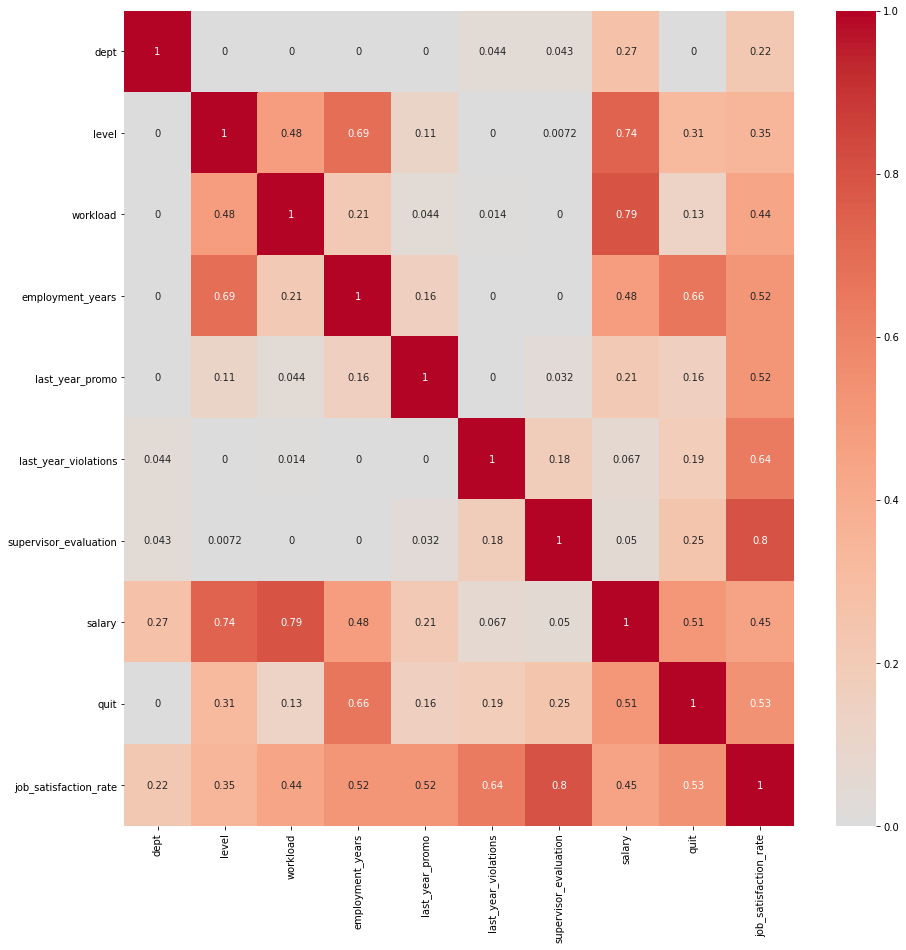

In [52]:
train_quit_no_id = train_quit.drop('id', axis=1)
corr = train_quit_no_id.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True)
None

### Вывод

1) Между признаками отсутсвует мультиколлинеарность 

2) 

* dept с таргетом не имеет линейную связь 

* level с таргетом имеет умеренную линейную зависимость 

* workload с таргетом имеет слабую линейную зависимость 

* employment_years с таргетом имеет заметную линейную зависимость

* last_year_promo с таргетом имеет слабую линейную зависимость 

* last_year_violations с таргетом имеет слабую линейную зависимость 

* supervisor_eveluation с таргетом имеет слабую линейную зависимость 

* salary с таргетом имеет заметную линейную зависимость

* job_satisfaction_rate с таргетом имеет заметную линейную зависимость

<a id='step_12'></a>

## Шаг 6. Подготовка данных

In [53]:
train_quit = train_quit.drop('id', axis=1)
check_nan_duplicates(train_quit)

dept                     0.0
level                    0.0
workload                 0.0
employment_years         0.0
last_year_promo          0.0
last_year_violations     0.0
supervisor_evaluation    0.0
salary                   0.0
quit                     0.0
job_satisfaction_rate    0.0
dtype: float64 

---------------- 

Проверка на явные дубликаты: 
Кол-во явных дубликатов: 1413 

---------------- 

Проверка на не явные дубликаты: 
dept ['sales' 'purchasing' 'marketing' 'technology' 'hr'] 

level ['middle' 'junior' 'senior'] 

workload ['high' 'medium' 'low'] 

last_year_promo ['no' 'yes'] 

last_year_violations ['no' 'yes'] 

quit ['no' 'yes'] 

---------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   wo

Удалим явные дубликаты

In [54]:
train_quit = train_quit.drop_duplicates()
check_nan_duplicates(train_quit)

dept                     0.0
level                    0.0
workload                 0.0
employment_years         0.0
last_year_promo          0.0
last_year_violations     0.0
supervisor_evaluation    0.0
salary                   0.0
quit                     0.0
job_satisfaction_rate    0.0
dtype: float64 

---------------- 

Проверка на явные дубликаты: 
Кол-во явных дубликатов: 0 

---------------- 

Проверка на не явные дубликаты: 
dept ['sales' 'purchasing' 'marketing' 'technology' 'hr'] 

level ['middle' 'junior' 'senior'] 

workload ['high' 'medium' 'low'] 

last_year_promo ['no' 'yes'] 

last_year_violations ['no' 'yes'] 

quit ['no' 'yes'] 

---------------- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 0 to 3998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   2587 non-null   object 
 1   level                  2587 non-null   object 
 2   workl

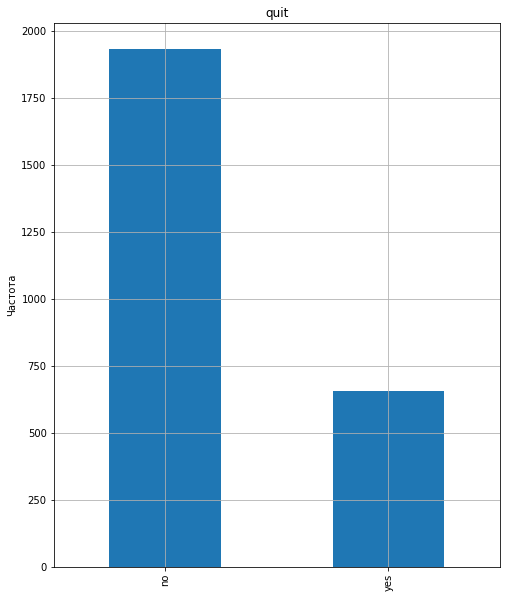

In [55]:
train_quit.groupby('quit')['quit'].count().plot(y=i, 
                              kind='bar', 
                              grid=True,
                              figsize=(8,10),
                              title='quit', 
                              xlabel=(''), 
                              ylabel=('Частота'), 
                                         )
None

### Вывод

Присутствует дисбаланс классов

In [56]:
RANDOM_STATE = 42
X_train = train_quit.drop('quit', axis=1)
y_train = train_quit['quit']

num_cols = X_train.select_dtypes(exclude='object').columns
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
ord_cols = ['level', 'workload']

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)

In [57]:
ohe_pipe = Pipeline(
[
    (
        'simpleImputer_ohe', 
        SimpleImputer(missing_values = np.nan, strategy='most_frequent')
    ),
    (
        'ohe',
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
    )
])

ord_pipe = Pipeline(
[
    (
        'simpleImputer_before_ord',
        SimpleImputer(missing_values = np.nan, strategy='most_frequent')
    ),
    (
        'ord',
        OrdinalEncoder(
            categories =[
                ['junior', 'middle', 'senior'],
                ['low', 'medium', 'high'],
            ],
            handle_unknown='use_encoded_value', unknown_value=np.nan
        )
    ),
    (
        'simpleImputer_after_ord',
        SimpleImputer(missing_values = np.nan, strategy='most_frequent')
    )
])

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols),
    ],
    remainder = 'passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': [0.1, 1, 0.01, 10, 0.001],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(1, 11),
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

<a id='step_13'></a>

## Шаг 7. Обучение модели

In [58]:
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    random_state= RANDOM_STATE,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc'
)

random_search.fit(X_train, y_train)

print('Лучшая модель и ее параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

**Предсказание увольнения сотрудника из компании**

In [59]:
test_features = test_features.merge(test_target_quit, on='id')

In [60]:
test_features = test_features.drop('id', axis=1)

In [61]:
X_test = test_features.drop('quit', axis=1)
y_test = test_features['quit']

y_test = label_encoder.transform(y_test)

y_pred = random_search.best_estimator_.predict_proba(X_test)[:, 1]

print(f'ROC_AUC: {roc_auc_score(y_test, y_pred)}')

ROC_AUC: 0.9235681018984966


Сравним лучшую модель с константной моделью

In [62]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)
X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()
)

In [63]:
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X_train_p, y_train)

y_pred = dummy_clf.predict_proba(X_test_p)[:, 1]

print(f'ROC-AUC: {roc_auc_score(y_test, y_pred)}')

ROC-AUC: 0.5


Константная модель по метрике хуже предсказываем, чем лучшая модель в RandomizedSearcgCV

**Анализ признаков**

In [64]:
def f(x):
    return random_search.best_estimator_.named_steps.models.predict_proba(x)[:, 1]


med = X_train_p.median().values.reshape((1, X_train_p.shape[1]))
explainer = shap.Explainer(f, med)
shap_values = explainer(X_train_p)
shap_values = explainer(X_test_p.iloc[0:1000, :])

PermutationExplainer explainer: 2588it [00:48, 45.24it/s]                          
PermutationExplainer explainer: 1001it [00:16, 21.97it/s]                         


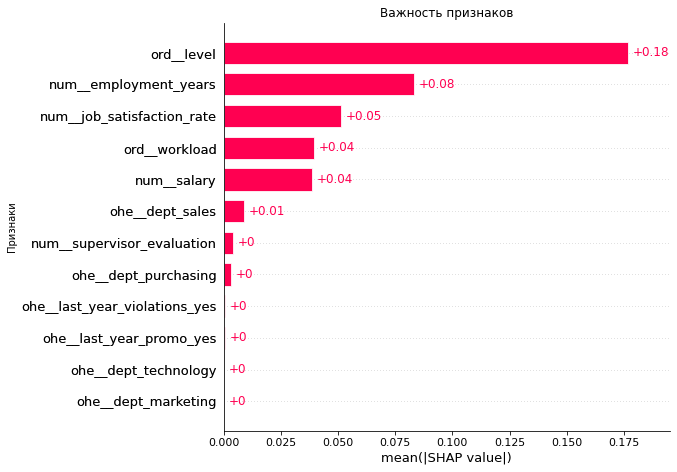

In [65]:
plt.title("Важность признаков") 
plt.ylabel("Признаки")

shap.plots.bar(shap_values, max_display=20) 

Удалим менее важные признаки 

In [66]:
X_new_train = X_train_p[['ohe__dept_sales', 'num__supervisor_evaluation', 'ohe__dept_purchasing', 'num__salary', 'ord__level', 'ord__workload', 'num__job_satisfaction_rate', 'num__employment_years']]

X_new_test = X_test_p[['ohe__dept_sales', 'num__supervisor_evaluation', 'ohe__dept_purchasing', 'num__salary', 'ord__level', 'ord__workload', 'num__job_satisfaction_rate', 'num__employment_years']]

In [67]:
random_search.best_estimator_.named_steps.models.fit(X_new_train, y_train)

y_pred = random_search.best_estimator_.named_steps.models.predict_proba(X_new_test)[:, 1]

print(f'ROC_AUC: {roc_auc_score(y_test, y_pred)}')

ROC_AUC: 0.9246855182836484


In [68]:
def f(x):
    return random_search.best_estimator_.named_steps.models.predict_proba(x)[:, 1]


med = X_new_train.median().values.reshape((1, X_new_train.shape[1]))
explainer = shap.Explainer(f, med)
shap_values = explainer(X_new_train)
shap_values = explainer(X_new_test.iloc[0:1000, :])

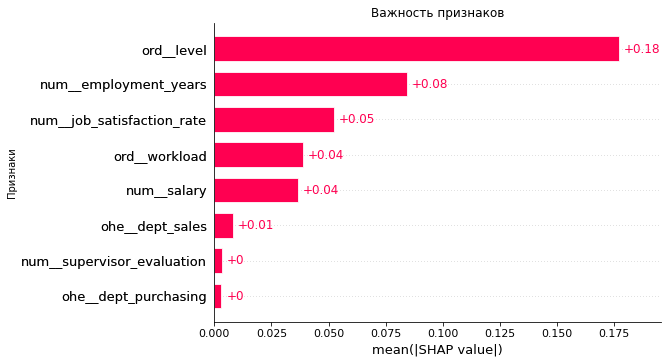

In [69]:
plt.title("Важность признаков") 
plt.ylabel("Признаки")
shap.plots.bar(shap_values, max_display=20) 

### Вывод

Больше всего влияет на то что сотрудник уволится:

1) Его уровень

2) Его загруженность

3) Его уровень удовлетворенности

4) Его стаж

5) Его Зарплаты 

### Вывод

1) Мы обучили 3 модели: Логистическая регрессия, дерево решений и kNN.

2) Лучшей по метрике ROC-AUC стала Дерево решений и она равняется 0.92

3) Гиперпараметры лучшей модели равняется: 'models__min_samples_split': 2, 'models__min_samples_leaf': 9, 'models__max_depth': 7

# Итоговые выводы

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Предобработка данных 

***train_job_satisfaction_rate***

1) Пропуски мы заполним в Pipeline

2) Явных дубликатов в данном DateFrame нет

3) Не явных дубликатов в данном DateFrame нет

***test_features***

1) Пропуски мы заполним в Pipeline

2) Явных дубликатов в данном DateFrame нет

3) В workload и dept изменили пустые значения на nan

***test_target_job_satisfaction_rate***

1) Пропусков в данном DateFrame нет

2) Явных дубликатов в данном DateFrame нет

3) Не явных дубликатов в данном DateFrame нет

---

### Исследовательский анализ данных

***train_job_satisfaction_rate***

1) Сотрудников больше всего в отделе продаж

2) Больше всего в кампании junior и меньше senior

3) У большинства уровень загруженности средний

4) У большинства не было повышение з/п за последний год

5) Большинство сотрудников не нарушали трудовой договор за последний год

6) Чем больше трудовой стаж, тем меньше сотрудников

7) Больше всего сотрудников с оценокй 4

8) Больше всего сотрудников с з/п от 20 тыс до 30 тыс

9) Выбросы присутствуют в признаке *salary*, но мы их удалять не будем, так как есть специалисты которые могут получать такую з/п

10) В признаке *supervisor_evaluation* присутствует выброс, но мы его удалять не будем, так как оценка качества работы сотрудника, которую дал руководитель может быть низкой

***test_features***

1) Сотрудников больше всего в отделе продаж

2) Больше всего в кампании junior и меньше senior

3) У большинства уровень загруженности средний

4) У большинства не было повышение з/п за последний год

5) Большинство сотрудников не нарушали трудовой договор за последний год

6) Чем больше трудовой стаж, тем меньше сотрудников

7) Больше всего сотрудников с оценокй 4

8) Больше всего сотрудников с з/п от 20 тыс до 30 тыс

9) Выбросы присутствуют в признаке *salary*, но мы их удалять не будем, так как есть специалисты которые могут получать такую з/п

10) В признаке *supervisor_evaluation* присутствует выброс, но мы его удалять не будем, так как оценка качества работы сотрудника, которую дал руководитель может быть низкой

***test_target_job_satisfaction_rate***

В данном DataFrame нет выбросов

**Во всех трех DataFrame количественные признаки нормально распределены**

---

### Корреляционный анализ 

1) Между признаками отсутсвует мультиколлинеарность 

2) 

* dept с таргетом не имеет линейную зависимость

* level с таргетом не имеет линейную зависимость

* workload с таргетом не имеет линейную зависимость

* employment_years с таргетом имеет умеренную линейную зависимость 

* last_year_promo с таргетом иммет слабую линейную зависимость 

* last_year_violations  с таргетом имеет заметную линейную зависимость 

* supervisor_evaluation с таргетом  имеет высокую линейную зависимость

* salary с таргетом иммет слабую линейную зависимость
---

### Обучение модели

1) Уровень удовлетворенности меньше всего зависит от отдела в котором он работает

2) Уровень удовлетворенности, больше всего зависит, как его оценивает руководитель

3) Мы обучили две модели: Линейную регресиию и Дерево решений

4) SMAPE лучшей модели равняется 14.8

5) Лучшие гиперпараметры для модели: 'models__min_samples_split': 4,'models__min_samples_leaf': 1, 'models__max_depth': 10,

6) Лучшая модель в RandomizedSearchCV намного лучше предсказывает чем константная модель

---

## Задача 2: предсказание увольнения сотрудника из компании

### Предобработка данных

***train_quit***

1) Пропусков в данном DateFrame нет

2) Явных дубликатов в данном DateFrame нет

3) Не явных дубликатов в данном DateFrame нет

***test_features***

1) Пропуски мы заполним в Pipeline

2) Явных дубликатов в данном DateFrame нет

3) В workload, level и dept изменили пустые значения на nan

***test_target_quit***

1) Пропусков в данном DateFrame нет

2) Явных дубликатов в данном DateFrame нет

3) Не явных дубликатов в данном DateFrame нет

### Исследовательский анализ 

***train_quit***

1) Сотрудников больше всего в отделе продаж

2) Больше всего в кампании junior и меньше senior

3) У большинства уровень загруженности средний

4) У большинства не было повышение з/п за последний год

5) Большинство сотрудников не нарушали трудовой договор за последний год

6) Чем больше трудовой стаж, тем меньше сотрудников

7) Больше всего сотрудников с оценокй 4

8) Больше всего сотрудников с з/п от 20 тыс до 30 тыс

9) В кампании мало сотрудников которые уволились

10) Выбросы присутствуют в признаке salary, но мы их удалять не будем, так как есть специалисты которые могут получать такую з/п

11) В признаке supervisor_evaluation присутствует выброс, но мы его удалять не будем, так как оценка качества работы сотрудника, которую дал руководитель может равняться 1

***test_features***

1) Сотрудников больше всего в отделе продаж

2) Больше всего в кампании junior и меньше senior

3) У большинства уровень загруженности средний

4) У большинства не было повышение з/п за последний год

5) Большинство сотрудников не нарушали трудовой договор за последний год

6) Чем больше трудовой стаж, тем меньше сотрудников

7) Больше всего сотрудников с оценокй 4

8) Больше всего сотрудников с з/п от 20 тыс до 30 тыс

9) Выбросы присутствуют в признаке salary, но мы их удалять не будем, так как есть специалисты которые могут получать такую з/п

10) В признаке supervisor_evaluation присутствует выброс, но мы его удалять не будем, так как оценка качества работы сотрудника, которую дал руководитель может равняться 1

***test_target_quit***

1) В кампании мало сотрудников которые уволились

**В тех DataFrame, где есть количественные признаки, они нормально распределены**

---

### Портрет «уволившегося сотрудника»

1) Больше всего увольнений в отделе sales

2) Больше всего увольнений junior разработчиков

3) Больше всего увольнений сотрудников с низкой загруженностью

4) Больше всего увольнений тех сотрудников, у кого не было повышения з/п за последний год

5) Больше всего увольнений тех сотрудников, кто не нарушал трудовой договор за последний год

6) В сумме те сотрудники, которые были уволены меньше проработали, чем те которые остаться работать в организации

7) Чем больше стаж, тем меньше шанс, что сотрудник уволиться

8) Больше всего увольнений тех сотрудников, у кого оценка от руководителя равняется 3

9) Кто уволился в среднем з/п не превышала 25 тыс., а те кто продолжает работать, у них в среднем з/п выше 35 тыс.

10) Средняя оценка уровня удовлетворенности кто уволился намного меньше, чем у тех кто остался

---

### Добавление нового входного признака

1) Добавили в тренировочную и тестовую выборку признак с оценкой удовлетворенности сотрудников

---

### Корреляционный анализ 

1) Между признаками отсутсвует мультиколлинеарность 

2) 

* dept с таргетом не имеет линейную связь 

* level с таргетом имеет умеренную линейную зависимость 

* workload с таргетом имеет слабую линейную зависимость 

* employment_years с таргетом имеет заметную линейную зависимость

* last_year_promo с таргетом имеет слабую линейную зависимость 

* last_year_violations с таргетом имеет слабую линейную зависимость 

* supervisor_eveluation с таргетом имеет слабую линейную зависимость 

* salary с таргетом имеет заметную линейную зависимость

* job_satisfaction_rate с таргетом имеет заметную линейную зависимость 

---

### Обучение модели

1) Мы обучили 3 модели: Логистическая регрессия, дерево решений и kNN.

2) Лучшей по метрике ROC-AUC стала Дерево решений и она равняется 0.9

3) Гиперпараметры лучшей модели равняется: max_depth=3, min_samples_leaf=5, min_samples_split=7

Больше всего влияет на то что сотрудник уволится:

1) Его уровень

2) Его загруженность

3) Его уровень удовлетворенности

4) Его стаж

5) Его Зарплаты 

---

### Рекомендации для бизнеса по сокращению уровня ухода сотрудников

1) Нужно следить за уровнем удовлетворенности сотрудников

2) Поощерять сотрудников повышением з/п

3) Чем дольше работает сотрудник, тем меньше вероятность, что он уволится. Это значит, что сотрудникам не нравится условия работы и надо их улучшить 